## Final Project Submission

Please fill out:
* Student name: Qilun Chen, 
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

# Data cleaning

In [210]:
data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [211]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [212]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
view              object
condition         object
grade             object
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [213]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [214]:
data['view'].head()

0    NONE
1    NONE
2    NONE
3    NONE
4    NONE
Name: view, dtype: object

In [215]:
data['waterfront'].head()

0    NaN
1     NO
2     NO
3     NO
4     NO
Name: waterfront, dtype: object

In [216]:
data['yr_renovated'].head()

0       0.0
1    1991.0
2       NaN
3       0.0
4       0.0
Name: yr_renovated, dtype: float64

In [217]:
data['view'] = data['view'].fillna('None')

In [218]:
data['waterfront'] = data['waterfront'].fillna('NO')

In [219]:
data['yr_renovated'] = data['yr_renovated'].fillna(0)

In [220]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [221]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.010612,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.117855,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.017900,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.047177,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.051060,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004979,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003793,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.020645,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.202555,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.010612,0.117855,0.017900,0.047177,0.051060,0.004979,0.003793,0.020645,-0.202555,1.000000,0.062397,0.027970,-0.064543,0.000683,0.004286


In [222]:
data['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

In [223]:
data[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']].head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,1180,5650,1180,0.0,1340,5650
1,2570,7242,2170,400.0,1690,7639
2,770,10000,770,0.0,2720,8062
3,1960,5000,1050,910.0,1360,5000
4,1680,8080,1680,0.0,1800,7503


In [224]:
data['floors'].value_counts()

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [225]:
data.drop(columns = 'lat', inplace = True)

In [226]:
data.drop(columns = 'long', inplace = True)

In [227]:
data['propertyTaxPerYear'] = data['price'] * 0.0101

In [228]:
data['livingAreaRatio'] = data['sqft_living'] / data['sqft_lot']

In [229]:
data['livingAreaRatio'].head()

0    0.208850
1    0.354874
2    0.077000
3    0.392000
4    0.207921
Name: livingAreaRatio, dtype: float64

In [230]:
data['houseAge'] = 2022 - data['yr_built']

In [231]:
data['pricePerSqft'] = data['price'] / data['sqft_lot']

In [232]:
data['date'].head()

0    10/13/2014
1     12/9/2014
2     2/25/2015
3     12/9/2014
4     2/18/2015
Name: date, dtype: object

In [233]:
data['date'] = pd.to_datetime(data['date'])

In [234]:
data['year_sold'] = data['date'].dt.year

In [235]:
data['year_sold'].head()

0    2014
1    2014
2    2015
3    2014
4    2015
Name: year_sold, dtype: int64

In [236]:
data[['price','floors']].corr()

,price,floors
price,1.000000,0.256804
floors,0.256804,1.000000


# If you are builders

## Linear Regression

### looking for great land lot rebuild to mixed-use house

find high demand zip code. find big lot with small house in the area. find house house 

In [237]:
data['zipcode'].value_counts().head(9)

98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
Name: zipcode, dtype: int64

In [238]:
data.corr()['pricePerSqft']

id                    0.059813
price                 0.308066
bedrooms             -0.062884
bathrooms             0.202578
sqft_living           0.022404
sqft_lot             -0.206256
floors                0.477914
sqft_above           -0.004770
yr_built              0.124420
yr_renovated          0.034789
zipcode               0.221420
sqft_living15        -0.044397
sqft_lot15           -0.228634
propertyTaxPerYear    0.308066
livingAreaRatio       0.896127
houseAge             -0.124420
pricePerSqft          1.000000
year_sold             0.010053
Name: pricePerSqft, dtype: float64

In [239]:
data.corr()['sqft_living']

id                   -0.012241
price                 0.701917
bedrooms              0.578212
bathrooms             0.755758
sqft_living           1.000000
sqft_lot              0.173453
floors                0.353953
sqft_above            0.876448
yr_built              0.318152
yr_renovated          0.051060
zipcode              -0.199802
sqft_living15         0.756402
sqft_lot15            0.184342
propertyTaxPerYear    0.701917
livingAreaRatio       0.076988
houseAge             -0.318152
pricePerSqft          0.022404
year_sold            -0.029014
Name: sqft_living, dtype: float64

In [240]:
simple_formula = 'pricePerSqft~price'
simple_model = ols(simple_formula, data).fit()
simple_model_summary = simple_model.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pricePerSqft   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2264.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:48:53   Log-Likelihood:            -1.2770e+05
No. Observations:               21597   AIC:                         2.554e+05
Df Residuals:                   21595   BIC:                         2.554e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.3725      1.083     42.819      0.000      44.250      48.495
price       7.888e-05   1.66e-06     47.585      0.000    7.56e-05    8.21e-05
==============================================================================
Omnibus:                    16212.990   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           489434.062
Skew:                           3.325   Prob(JB):                         0.00
Kurtosis:                      25.354   Cond. No.                     1.16e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [241]:
multiple_formula = 'pricePerSqft~price+livingAreaRatio'
multiple_model = ols(multiple_formula, data).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           pricePerSqft   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 5.787e+04
Date:                Tue, 29 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:48:53   Log-Likelihood:            -1.0880e+05
No. Observations:               21597   AIC:                         2.176e+05
Df Residuals:                   21594   BIC:                         2.176e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -37.6399      0.522    -72.108      0.000     -38.663     -36.617
price            5.142e-05   6.96e-07     73.858      0.000    5.01e-05    5.28e-05
livingAreaRatio   305.3147      0.953    320.480      0.000     303.447     307.182
==============================================================================
Omnibus:                    10329.168   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           334462.306
Skew:                           1.680   Prob(JB):                         0.00
Kurtosis:                      21.984   Cond. No.                     2.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [242]:
data['livingAreaRatio'].mean()

0.32375545559503777

In [243]:
df = data[['price','sqft_living', 'sqft_lot', 'floors', 'sqft_above','livingAreaRatio','houseAge','pricePerSqft','zipcode']]
df

,price,sqft_living,sqft_lot,floors,sqft_above,livingAreaRatio,houseAge,pricePerSqft,zipcode
0,221900.0,1180,5650,1.0,1180,0.208850,67,39.274336,98178
1,538000.0,2570,7242,2.0,2170,0.354874,71,74.288870,98125
2,180000.0,770,10000,1.0,770,0.077000,89,18.000000,98028
3,604000.0,1960,5000,1.0,1050,0.392000,57,120.800000,98136
4,510000.0,1680,8080,1.0,1680,0.207921,35,63.118812,98074
...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,1131,3.0,1530,1.352785,13,318.302387,98103
21593,400000.0,2310,5813,2.0,2310,0.397385,8,68.811285,98146
21594,402101.0,1020,1350,2.0,1020,0.755556,13,297.852593,98144
21595,400000.0,1600,2388,2.0,1600,0.670017,18,167.504188,98027


In [244]:
zipcode_df = df.groupby(by = ["zipcode"]).mean()

In [245]:
zipcode_df.sort_values(by = ['pricePerSqft'], ascending = False).head()

,price,sqft_living,sqft_lot,floors,sqft_above,livingAreaRatio,houseAge,pricePerSqft
zipcode,,,,,,,,
98102,8.996077e+05,2151.048077,3605.153846,1.990385,1752.442308,0.777736,69.836538,322.561090
98119,8.497148e+05,2005.614130,3615.217391,1.793478,1589.961957,0.692205,74.380435,287.432530
98109,8.800778e+05,2054.779817,3621.082569,1.729358,1637.348624,0.671971,77.972477,281.081375
98112,1.096239e+06,2498.743494,4990.431227,1.806691,2005.695167,0.621954,77.550186,261.968320
98107,5.791098e+05,1579.548872,3194.368421,1.834586,1317.218045,0.660090,62.368421,243.382314


### focus on 98102

In [246]:
df_98102 = data[data['zipcode'] == 98102]

In [247]:
df_98102.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,houseAge,pricePerSqft,year_sold
count,1.040000e+02,1.040000e+02,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.0,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,4.102040e+09,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,1.990385,1752.442308,1952.163462,76.576923,98102.0,1954.471154,3303.500000,9086.037498,0.777736,69.836538,322.561090,2014.259615
std,2.636774e+09,7.903814e+05,1.146967,0.936100,1416.956148,3738.541805,0.535084,1034.478508,43.927591,384.748000,0.0,592.328447,1875.940893,7982.851802,0.360766,43.927591,160.708592,0.440547
min,9.520067e+08,3.300000e+05,2.000000,1.000000,710.000000,857.000000,1.000000,710.000000,1900.000000,0.000000,98102.0,1120.000000,1079.000000,3333.000000,0.156333,8.000000,64.257231,2014.000000
25%,1.965075e+09,5.718750e+05,3.000000,1.750000,1370.000000,1339.250000,2.000000,1171.000000,1910.000000,0.000000,98102.0,1515.000000,1438.750000,5775.937500,0.501136,17.000000,185.116700,2014.000000
50%,2.902200e+09,7.100000e+05,3.000000,2.250000,1780.000000,3085.500000,2.000000,1585.000000,1926.500000,0.000000,98102.0,1810.000000,3210.000000,7171.000000,0.667841,95.500000,286.857143,2014.000000
75%,6.762700e+09,9.761750e+05,4.000000,2.750000,2480.000000,4400.000000,2.000000,2070.000000,2005.000000,0.000000,98102.0,2230.000000,4500.000000,9859.367500,1.082727,112.000000,418.141206,2015.000000
max,9.831201e+09,7.700000e+06,9.000000,8.000000,12050.000000,27600.000000,3.000000,8570.000000,2014.000000,2014.000000,98102.0,3940.000000,11500.000000,77770.000000,1.738623,122.000000,738.833333,2015.000000


I am going to be to develop a pricing algorithm to help set a target price for new house that are released to market. The goal is to tell the customer new price and to help ensure consistency in pricing between new products and past products.

In [248]:
x_train_98102 = df_98102


x_train_98102 = x_train_98102.drop(["price","pricePerSqft","propertyTaxPerYear", "salesTax"],axis = 1)
y_train_98102 = df_98102["price"]

x_train_98102

KeyError: "['salesTax'] not found in axis"

In [249]:
x_train_98102.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 100 to 21567
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  104 non-null    int64         
 1   date                104 non-null    datetime64[ns]
 2   price               104 non-null    float64       
 3   bedrooms            104 non-null    int64         
 4   bathrooms           104 non-null    float64       
 5   sqft_living         104 non-null    int64         
 6   sqft_lot            104 non-null    int64         
 7   floors              104 non-null    float64       
 8   waterfront          104 non-null    object        
 9   view                104 non-null    object        
 10  condition           104 non-null    object        
 11  grade               104 non-null    object        
 12  sqft_above          104 non-null    int64         
 13  sqft_basement       104 non-null    object    

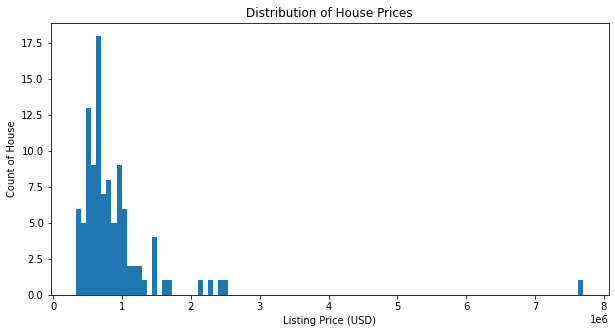

In [250]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_train_98102, bins=100)

ax.set_xlabel("Listing Price (USD)")
ax.set_ylabel("Count of House")
ax.set_title("Distribution of House Prices");

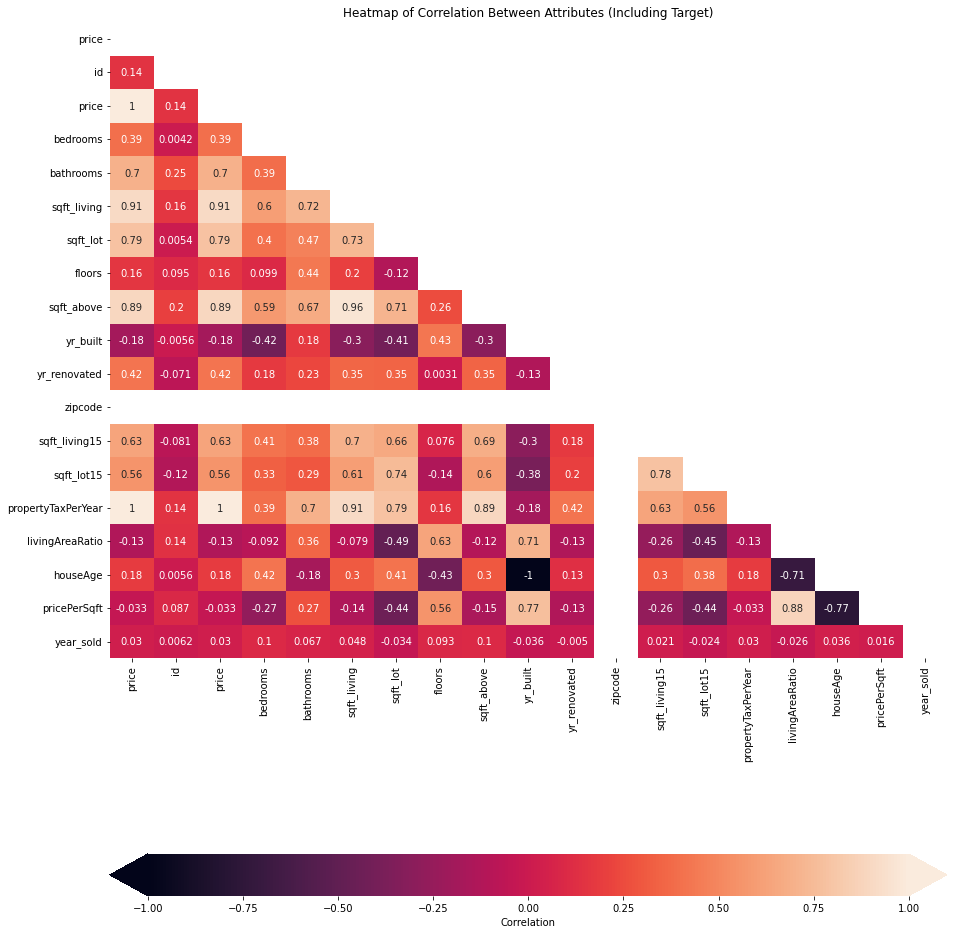

In [251]:
heatmap_data = pd.concat([y_train_98102, x_train_98102], axis=1)
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(15, 18))

sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [252]:
most_correlated_feature = "sqft_living"

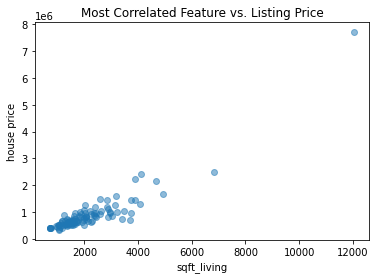

In [253]:
fig, ax = plt.subplots()

ax.scatter(x_train_98102[most_correlated_feature], y_train_98102, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("house price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [254]:

baseline_model = LinearRegression()

In [255]:

from sklearn.model_selection import cross_validate, ShuffleSplit

splitter = ShuffleSplit(n_splits=3, test_size=0.25, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train_98102[[most_correlated_feature]],
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [256]:

X_train_numeric = x_train_98102.select_dtypes("number").copy()

X_train_numeric

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,houseAge,pricePerSqft,year_sold
100,1952200240,850830.0,3,2.50,2070,13241,1.5,1270,1910,0.0,98102,2200,4500,8593.383,0.156333,112,64.257231,2014
327,1959700550,740000.0,4,2.00,2050,4400,1.5,2050,1922,0.0,98102,2320,5500,7474.000,0.465909,100,168.181818,2014
673,1959701890,865000.0,4,1.75,1800,4180,2.0,1800,1921,0.0,98102,2180,4620,8736.500,0.430622,101,206.937799,2014
890,1962200435,1010000.0,4,1.00,1820,5400,1.5,1820,1923,2014.0,98102,1820,5400,10201.000,0.337037,99,187.037037,2014
961,6852700478,425000.0,2,1.00,970,2970,1.0,970,1910,0.0,98102,1670,3000,4292.500,0.326599,112,143.097643,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20901,6762700452,575000.0,3,3.00,1384,1287,2.0,1144,2006,0.0,98102,1570,1288,5807.500,1.075369,16,446.775447,2014
20910,6852700097,630000.0,3,3.25,1610,1275,2.0,1220,2005,0.0,98102,1750,3000,6363.000,1.262745,17,494.117647,2014
21055,2163900081,1080000.0,3,2.50,1990,1891,3.0,1990,2012,0.0,98102,1990,3600,10908.000,1.052353,10,571.126388,2015
21184,1959700225,720000.0,3,1.75,1370,1990,3.0,1370,2014,0.0,98102,1730,1990,7272.000,0.688442,8,361.809045,2015


IndexError: index 5 is out of bounds for axis 0 with size 5

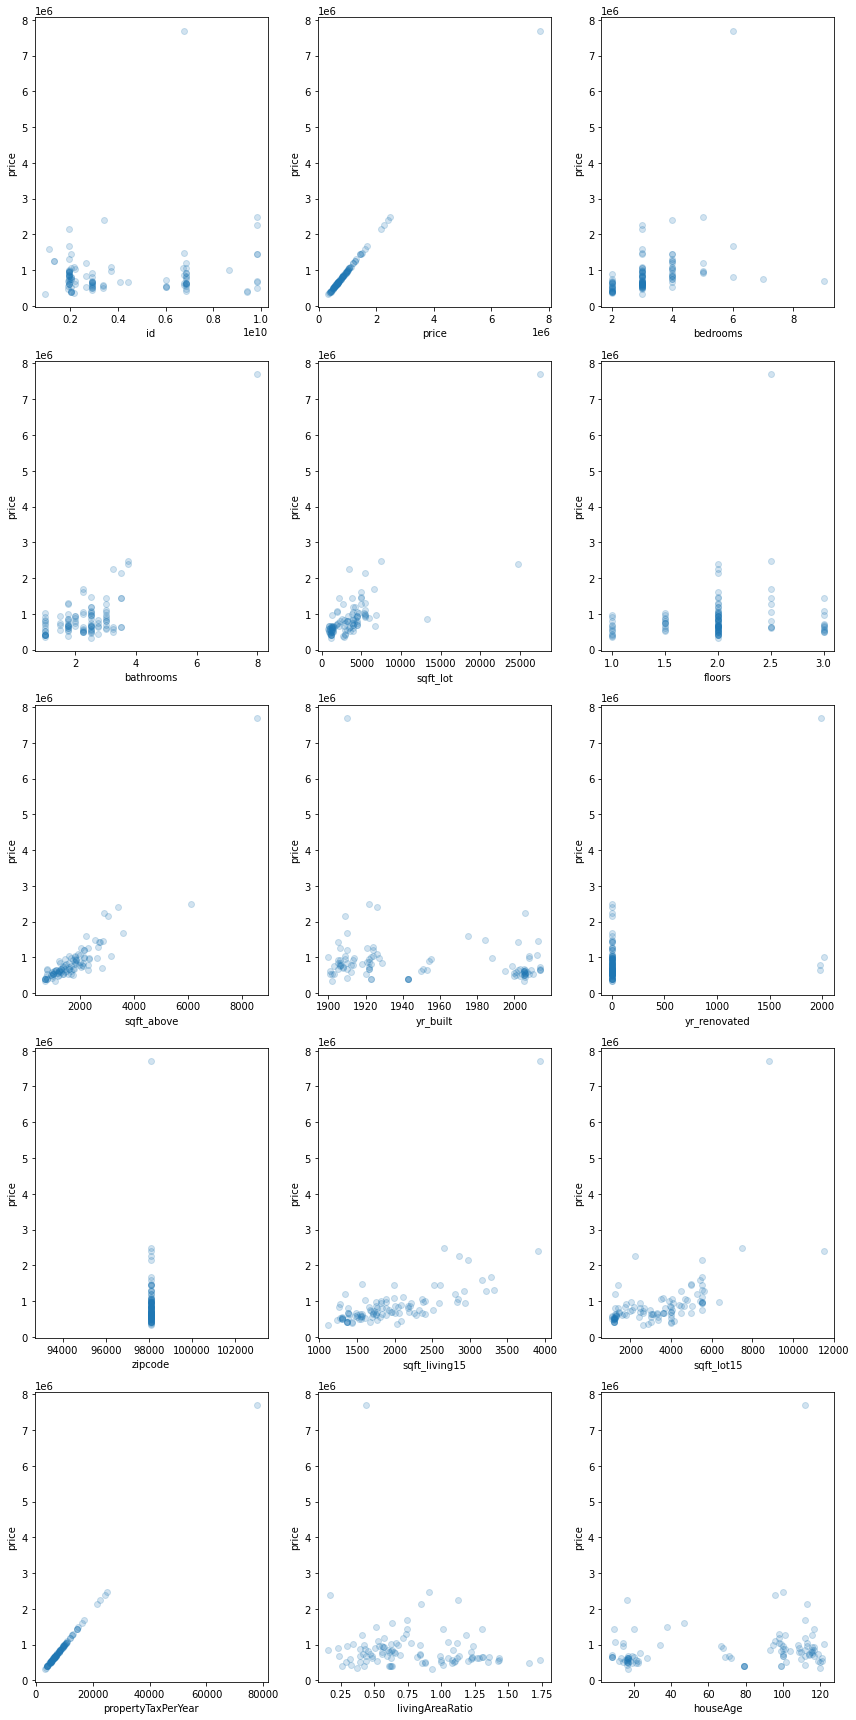

In [257]:

scatterplot_data = X_train_numeric.drop("sqft_living", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(12, 24))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(X_train_numeric[col], y_train_98102, alpha=0.2)
    ax.set_xlabel(col)
    ax.set_ylabel("price")

In [ ]:

X_train_second_model = X_train_numeric.drop(["id", "year_sold", "zipcode", "yr_renovated"], axis=1).copy()

X_train_second_model

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,livingAreaRatio,houseAge
100,3,2.50,2070,13241,1.5,1270,1910,2200,4500,0.156333,112
327,4,2.00,2050,4400,1.5,2050,1922,2320,5500,0.465909,100
673,4,1.75,1800,4180,2.0,1800,1921,2180,4620,0.430622,101
890,4,1.00,1820,5400,1.5,1820,1923,1820,5400,0.337037,99
961,2,1.00,970,2970,1.0,970,1910,1670,3000,0.326599,112
...,...,...,...,...,...,...,...,...,...,...,...
20901,3,3.00,1384,1287,2.0,1144,2006,1570,1288,1.075369,16
20910,3,3.25,1610,1275,2.0,1220,2005,1750,3000,1.262745,17
21055,3,2.50,1990,1891,3.0,1990,2012,1990,3600,1.052353,10
21184,3,1.75,1370,1990,3.0,1370,2014,1730,1990,0.688442,8


In [ ]:

second_model = LinearRegression()

second_model_scores = cross_validate(
    estimator=second_model,
    X=X_train_second_model,
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.9382115679416976
Validation score: 0.5796555037998196

Baseline Model
Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [ ]:
import statsmodels.api as sm

sm.OLS(y_train_98102, sm.add_constant(X_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     112.0
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           2.37e-47
Time:                        15:05:01   Log-Likelihood:                -1425.9
No. Observations:                 104   AIC:                             2874.
Df Residuals:                      93   BIC:                             2903.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.1765      0.406     -2.897      0.005      -1.983      -0.370
bedrooms        -1.299e+05   2.72e+04     -4.781      0.000   -1.84e+05   -7.59e+04
bathrooms        3.546e+04   5.17e+04      0.686      0.495   -6.72e+04    1.38e+05
sqft_living       407.9780     81.996      4.976      0.000     245.149     570.807
sqft_lot           64.4595     13.671      4.715      0.000      37.312      91.607
floors          -2.003e+04   6.78e+04     -0.295      0.768   -1.55e+05    1.15e+05
sqft_above        144.4075     97.694      1.478      0.143     -49.594     338.409
yr_built          259.6963     87.321      2.974      0.004      86.295     433.098
sqft_living15      29.4655     71.129      0.414      0.680    -111.782     170.713
sqft_lot15        -79.1255     23.171     -3.415      0.001    -125.139     -33.112
livingAreaRatio -2.588e+05   1.52e+05     -1.705      0.092    -5.6e+05    4.26e+04
houseAge        -2638.6485    866.119     -3.047      0.003   -4358.590    -918.707
==============================================================================
Omnibus:                        6.945   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.031   Jarque-Bera (JB):               12.408
Skew:                           0.066   Prob(JB):                      0.00202
Kurtosis:                       4.687   Cond. No.                     2.16e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.21e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
significant_features = ["sqft_living", "sqft_living15"]

In [ ]:
third_model = LinearRegression()
X_train_third_model = x_train_98102[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=X_train_third_model,
    y=y_train_98102,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.8575898361852675
Validation score: 0.2880030679852374

Second Model
Train score:      0.9382115679416976
Validation score: 0.5796555037998196

Baseline Model
Train score:      0.8571585347927156
Validation score: 0.30493302786183335


In [ ]:

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler

# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
X_train_for_RFECV = StandardScaler().fit_transform(X_train_second_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(X_train_for_RFECV, y_train_98102)

# Print the results
print("Was the column selected?")
for index, col in enumerate(X_train_second_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
bathrooms: True
sqft_living: True
sqft_lot: True
floors: False
sqft_above: True
yr_built: True
sqft_living15: False
sqft_lot15: True
livingAreaRatio: True
houseAge: True


# Hypothesis Testing

### renovated house has more value

In [258]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,propertyTaxPerYear,livingAreaRatio,houseAge,pricePerSqft,year_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,...,1955,0.0,98178,1340,5650,2241.19,0.208850,67,39.274336,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,1690,7639,5433.80,0.354874,71,74.288870,2014
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,0.0,98028,2720,8062,1818.00,0.077000,89,18.000000,2015
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,1360,5000,6100.40,0.392000,57,120.800000,2014
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,1800,7503,5151.00,0.207921,35,63.118812,2015


In [259]:
data['yr_renovated'].describe()

count    21597.000000
mean        68.758207
std        364.037499
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [260]:
data['yr_renovated'].value_counts()

0.0       20853
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64

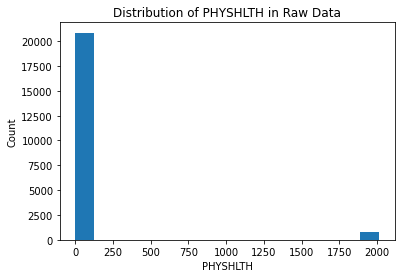

In [263]:
fig, ax = plt.subplots()
ax.hist(data['yr_renovated'], bins="auto")
ax.set_xlabel("PHYSHLTH")
ax.set_ylabel("Count")
ax.set_title("Distribution of PHYSHLTH in Raw Data");